##  환경 설정 및 라이브러리 임포트

In [ ]:
# !pip install datasets transformers
# pip install ipywidgets

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding

print("라이브러리 임포트 완료")

라이브러리 임포트 완료


## 데이터 준비 및 EDA

In [3]:
# 데이터셋 로드
dataset = load_dataset("Wittgensteinian/KR3", split='train')

# 불필요한 컬럼 제거
dataset = dataset.remove_columns(['__index_level_0__'])

print("데이터셋 정보:")
print(dataset)

데이터셋 정보:
Dataset({
    features: ['Rating', 'Review'],
    num_rows: 641762
})


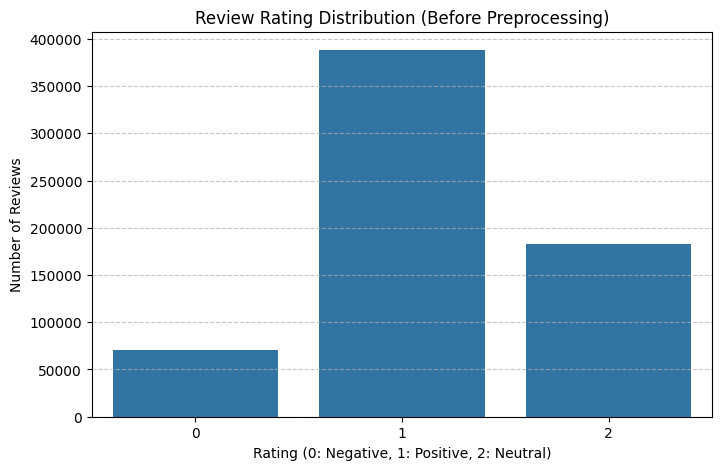


- Original data count: 641,762 rows
- Data count after removing neutral reviews: 459,021 rows


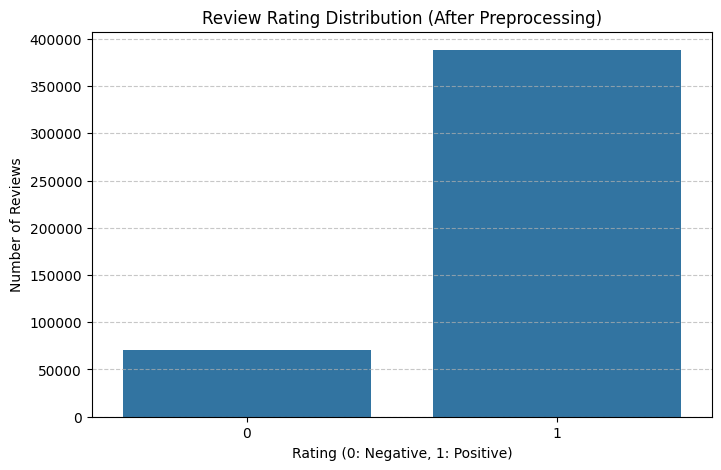

In [4]:
# 2.1. 전처리 전 데이터 분포 시각화
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=pd.DataFrame(dataset))
plt.title('Review Rating Distribution (Before Preprocessing)')
plt.xlabel('Rating (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2.2. 평점이 2인 중립 리뷰 제거
filtered_dataset = dataset.filter(lambda x: x['Rating'] != 2)
print(f"\n- Original data count: {len(dataset):,} rows")
print(f"- Data count after removing neutral reviews: {len(filtered_dataset):,} rows")

# 2.3. 전처리 후 데이터 분포 시각화
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=pd.DataFrame(filtered_dataset))
plt.title('Review Rating Distribution (After Preprocessing)')
plt.xlabel('Rating (0: Negative, 1: Positive)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## - KoGPT2 Tokenzier & Model
    - GPT-2 trained on Korean corpus: https://github.com/SKT-AI/KoGPT2

In [5]:
# 모델 정의
MODEL_NAME = "skt/kogpt2-base-v2"

# 모델 및 토크나이저 불러오기
# 토크나이저에 padding token을 추가합니다.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, pad_token='<pad>')
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f" 모델({MODEL_NAME}) 및 토크나이저 로딩 완료")
print(f" 사용 디바이스: {device}")

 모델(skt/kogpt2-base-v2) 및 토크나이저 로딩 완료
 사용 디바이스: cuda


In [6]:
len(tokenizer.vocab)

51201

## 제로샷 분류(Zero-Shot Classification) 로직 설계

In [7]:
# 긍정/부정 판단의 기준이 될 단어와 토큰 ID 정의
POSITIVE_PROMPT = "최고"
NEGATIVE_PROMPT = "별로"

positive_token_id = tokenizer.encode(POSITIVE_PROMPT)[0]
negative_token_id = tokenizer.encode(NEGATIVE_PROMPT)[0]

print(f"'{POSITIVE_PROMPT}'의 토큰 ID: {positive_token_id}")
print(f"'{NEGATIVE_PROMPT}'의 토큰 ID: {negative_token_id}")

'최고'의 토큰 ID: 10281
'별로'의 토큰 ID: 15126


In [8]:
# 샘플 데이터
sample_idx = 0
sample_review = filtered_dataset['Review'][sample_idx]
sample_label = filtered_dataset['Rating'][sample_idx]

# 1. 리뷰 토큰화
inputs = tokenizer(sample_review, return_tensors='pt').to(device)

# 2. 모델 추론
with torch.no_grad():
    outputs = model(**inputs)

# 3. 마지막 토큰의 예측값(logits) 추출
# Logits: 모델이 각 단어를 얼마나 가능성 있게 예측했는지를 나타내는 정규화되지 않은 점수
last_token_logits = outputs.logits[0, -1, :]

# 4. 긍정/부정 프롬프트 토큰의 점수 비교
positive_score = last_token_logits[positive_token_id]
negative_score = last_token_logits[negative_token_id]
prediction = 1 if positive_score > negative_score else 0

# 결과 출력
print(f"샘플 리뷰: \"{sample_review[:100]}...\"")
print(f"실제 라벨: {'긍정' if sample_label == 1 else '부정'}")
print("-" * 30)
print(f"'{POSITIVE_PROMPT}' 점수: {positive_score:.2f}")
print(f"'{NEGATIVE_PROMPT}' 점수: {negative_score:.2f}")
print(f"모델 예측: {'긍정' if prediction == 1 else '부정'}")
print(f"결과: {'정답' if prediction == sample_label else '오답'}")

샘플 리뷰: "숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편이고 살짝 레트로 감성으로 분위기 잡아놨습니다. 모든 직원분들께서 전부 가능하다고 멘트 쳐주시며,..."
실제 라벨: 긍정
------------------------------
'최고' 점수: 7.13
'별로' 점수: 5.93
모델 예측: 긍정
결과: 정답


## 전체 데이터셋 추론 및 평가

In [9]:
# --- 상수 정의 ---
MAX_LENGTH = 256
BATCH_SIZE = 32 # GPU 메모리에 따라 조절

# 토큰화 함수
def tokenize_function(examples):
    return tokenizer(examples['Review'], max_length=MAX_LENGTH, truncation=True)

# 전체 데이터셋에 토큰화 적용 (batched=True로 병렬 처리하여 속도 향상)
tokenized_dataset = filtered_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['Review'])
tokenized_dataset.set_format('torch')

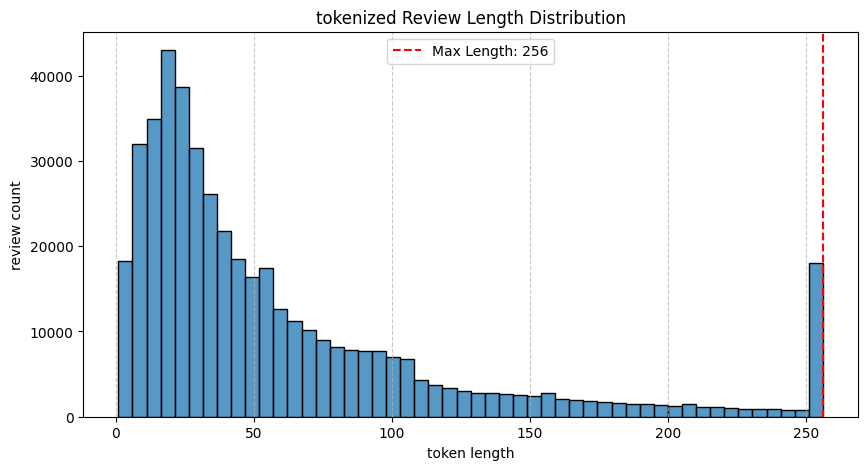

In [10]:
# 토큰화 후 리뷰 길이 분포 시각화
review_lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.figure(figsize=(10, 5))
sns.histplot(review_lengths, bins=50)
plt.title('tokenized Review Length Distribution')
plt.xlabel('token length')
plt.ylabel('review count')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', label=f'Max Length: {MAX_LENGTH}')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 데이터 로더 생성
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_loader = DataLoader(
    tokenized_dataset, 
    batch_size=BATCH_SIZE, 
    collate_fn=data_collator
)

In [ ]:
def evaluate(model, dataloader, pos_token_id, neg_token_id, device):
    """모델의 성능을 평가하고 혼동 행렬을 반환하는 함수"""
    model.eval()  # 모델을 평가 모드로 설정
    
    # 혼동 행렬         : [[TN, FP], [FN, TP]]
    # TN(True Negative) : 실제 부정(0) -> 예측 부정(0)
    # FP(False Positive): 실제 부정(0) -> 예측 긍정(1)
    # FN(False Negative): 실제 긍정(1) -> 예측 부정(0)
    # TP(True Positive) : 실제 긍정(1) -> 예측 긍정(1)
    confusion_matrix = [[0, 0], [0, 0]]
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # 데이터를 GPU로 이동
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop('Rating') # 라벨 분리
            
            # 모델 추론
            outputs = model(**batch)
            
            # 각 리뷰의 실제 길이 (패딩 제외)
            input_lens = batch['attention_mask'].sum(axis=1)

            for i in range(len(input_lens)):
                # 마지막 토큰의 logits 추출
                last_token_logits = outputs.logits[i, input_lens[i]-1, :]
                
                # 예측
                predicted_label = 1 if last_token_logits[pos_token_id] > last_token_logits[neg_token_id] else 0
                true_label = labels[i].item()
                
                # 혼동 행렬 업데이트
                confusion_matrix[true_label][predicted_label] += 1
                
    return np.array(confusion_matrix)

confusion_matrix = evaluate(model, data_loader, positive_token_id, negative_token_id, device)

## 결과 분석 및 시각화

In [ ]:
# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['부정 (예측)', '긍정 (예측)'], 
            yticklabels=['부정 (실제)', '긍정 (실제)'])
plt.title('혼동 행렬 (Confusion Matrix)')
plt.ylabel('실제 라벨')
plt.xlabel('예측 라벨')
plt.show()

# 성능 지표 계산
TN, FP, FN, TP = confusion_matrix.flatten()

accuracy = (TP + TN) / (TP + TN + FP + FN)
positive_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
positive_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
negative_precision = TN / (TN + FN) if (TN + FN) > 0 else 0
negative_recall = TN / (TN + FP) if (TN + FP) > 0 else 0

# 결과 출력
print("\n--- 모델 성능 평가 결과 ---")
print(f" 전체 정확도 (Accuracy): {accuracy:.4f}")
print("\n[긍정 리뷰에 대한 성능]")
print(f"  - 정밀도 (Precision): {positive_precision:.4f}")
print(f"  - 재현율 (Recall): {positive_recall:.4f}")
print("\n[부정 리뷰에 대한 성능]")
print(f"  - 정밀도 (Precision): {negative_precision:.4f}")
print(f"  - 재현율 (Recall): {negative_recall:.4f}")

In [ ]:
confusion_matrix